# Introduction to Deep Learning

In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

You are given a dataset containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
- a test set of m_test images labeled as cat or non-cat
- each image is of shape `(num_px, num_px, 3)` where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [3]:
def loadDataset():
    trainDataset = h5py.File("train_catvnoncat.h5", "r")
    trainDatasetX = np.array(trainDataset["train_set_x"][:])
    trainDatasetY = np.array(trainDataset["train_set_y"][:])
    
    testDataset = h5py.File("test_catvnoncat.h5")
    testDatasetX = np.array(testDataset["test_set_x"][:])
    testDatasetY = np.array(testDataset["test_set_y"][:])

    classes = np.array(trainDataset["list_classes"][:])

    trainDatasetY = trainDatasetY.reshape((1, trainDatasetY.shape[0]))
    testDatasetY = testDatasetY.reshape((1, testDatasetY.shape[0]))
    return trainDatasetX, trainDatasetY, testDatasetX, testDatasetY, classes

trainDatasetX, trainDatasetY, testDatasetX, testDatasetY, classes = loadDataset()
print(trainDatasetX.shape, trainDatasetY.shape)

(209, 64, 64, 3) (1, 209)


Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

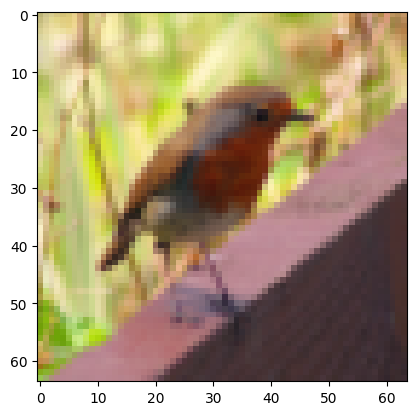

y = 0, it's a 'non-cat' picture.


In [4]:
index = 10
plt.imshow(trainDatasetX[index])
plt.show()
print ("y = " + str(trainDatasetY[0, index]) + ", it's a '" + classes[np.squeeze(trainDatasetY[:, index])].decode("utf-8") +  "' picture.")

Find the values for:
- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)  
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [5]:
m_train = trainDatasetX.shape[0]
m_test = testDatasetX.shape[0]
num_px = trainDatasetX.shape[1]

# let's print some usefull imformation
print("Number of training examples: ", m_train)
print("Number of testing examples: ", m_test)
print("Height of image: ", num_px, "px")
print("Shape of image: ", trainDatasetX[0].shape)
print("Shape of training dataset X: ", trainDatasetX.shape)
print("Shape of training dataset Y: ", trainDatasetY.shape)

Number of training examples:  209
Number of testing examples:  50
Height of image:  64 px
Shape of image:  (64, 64, 3)
Shape of training dataset X:  (209, 64, 64, 3)
Shape of training dataset Y:  (1, 209)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b * c * d, a) is to use: 
```
X_flatten = X.reshape(X.shape[0], -1).T
```

In [6]:
XTrainFlatten = trainDatasetX.reshape(trainDatasetX.shape[0], -1).T
XTestFlatten = testDatasetX.reshape(testDatasetX.shape[0], -1).T
print("Shape of XFlatten: ", XTrainFlatten.shape)
print("Shape of XTestFlatten: ", XTestFlatten.shape)

Shape of XFlatten:  (12288, 209)
Shape of XTestFlatten:  (12288, 50)


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [7]:
XTrainFlatten = XTrainFlatten / 255
XTestFlatten = XTestFlatten / 255

Sigmoid Function

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Initialize Parameters

In [9]:
def initializeParameters(dim):
    w = np.zeros((dim,1))
    b = 0
    return w, b

## Logistic Regression 
#### Forward Propagation
$$
Z = W^T X + b  \\
A = sigmoid(X) \\
$$
#### Calculate Cost
$$
J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})
$$
#### Backward Propagation
$$ \partial W = \frac{\partial J}{\partial W} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \partial b = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
#### Parameter Updation
$$ W = W - \alpha \text{ } \partial W $$
$$ b = b - \alpha \text{ } \partial b $$

Let's implements forward propagation, cost calculation and backward propagation in one function

In [10]:
def propagate(w, b, X, Y):
    m = X.shape[0]

    #forward prop
    Z = np.matmul(w.T,X) + b
    A = sigmoid(Z)

    #cost calculation
    cost = np.multiply(np.log(A), Y) + np.multiply(np.log(1-A), (1-Y))
    cost = (-1/m)*np.sum(cost)

    #backward prop
    dw = (1/m)*np.matmul(X, (A-Y).T)
    db = (1/m)*np.sum(A-Y)
    
    grad = {"dw": dw,
            "db": db}
    
    return grad, cost

Implement gradient decent for training our weights

In [11]:
def train_model(X, Y, numIterations, learningRate, printCost = False):
    nx = X.shape[0]
    m = X.shape[1]
    w, b = initializeParameters(nx)
    costs = []

    for i in range(numIterations):
        #forward propagation, cost calculation and backward propagation
        grad, cost = propagate(w, b, X, Y)
        costs.append(cost)
        #update weights
        w -= learningRate*grad['dw']
        b -= learningRate*grad['db']

        if(printCost and i%100==0):
            print(f"Cost after {i} iterations: {cost}")
    
    params = {"w": w,
              "b": b}
    
    return params, costs

In [12]:
params, costs = train_model(XTrainFlatten, trainDatasetY, numIterations = 2000, learningRate = 0.005, printCost = True)

Cost after 0 iterations: 0.01178936854956287
Cost after 100 iterations: 0.01096953816374258
Cost after 200 iterations: 0.010851810089621189
Cost after 300 iterations: 0.010744281759117374
Cost after 400 iterations: 0.010645248621166774
Cost after 500 iterations: 0.010553404307374739
Cost after 600 iterations: 0.010467686625806605
Cost after 700 iterations: 0.010387229097336916
Cost after 800 iterations: 0.010311321937133855
Cost after 900 iterations: 0.010239380876599629
Cost after 1000 iterations: 0.010170922361418571
Cost after 1100 iterations: 0.010105543864427857
Cost after 1200 iterations: 0.010042908265919222
Cost after 1300 iterations: 0.009982731451419457
Cost after 1400 iterations: 0.009924772447377094
Cost after 1500 iterations: 0.009868825556538004
Cost after 1600 iterations: 0.009814714069230701
Cost after 1700 iterations: 0.009762285217989494
Cost after 1800 iterations: 0.009711406114911085
Cost after 1900 iterations: 0.009661960467573172


Let's see how cost decrease with iterations

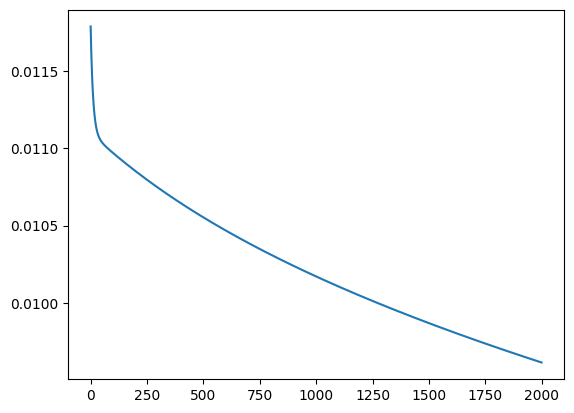

In [13]:
plt.plot(costs)
plt.show()

Let's Predict out model's output on train and test images and and see how our model performed

In [14]:
def predict(params, X, Y):
    w = params["w"]
    b = params["b"]
    Z = w.T.dot(X) + b
    A = sigmoid(Z)
    Y_Prediction = (A > 0.5) * 1.0
    return Y_Prediction

#checking accuracy
trainPrediction = predict(params, XTrainFlatten, trainDatasetY)
testPrediction = predict(params, XTestFlatten, testDatasetY)
print(f"train accuracy: {100-np.mean(np.abs(trainPrediction-trainDatasetY))*100}")
print(f"test accuracy: {100-np.mean(np.abs(testPrediction-testDatasetY))*100}")

train accuracy: 69.377990430622
test accuracy: 38.0
